# Optimizing Bankruptcy Prediction with K-NN, SMOTE, and Logistic Regression

## Introduction:

### Project Background:

The possibility of a company facing bankruptcy is a major concern in the economic and financial field. Predicting bankruptcy early can reduce risks and provide stakeholders with valuable information to make informed decisions. The project aims to leverage machine learning techniques to predict the probability of bankruptcy based on financial metrics. We particularly address the challenges posed by unbalanced datasets, which are common in bankruptcy prediction scenarios where the number of solvent companies far exceeds the number of insolvent companies.

### Main Question:

Can we accurately predict the likelihood of a company facing bankruptcy by applying SMOTE for data balancing, KNN for classification, and logistic regression for identifying key financial indicators? (That is, we are trying to build a model that can predict whether a company will go bankrupt)

### Dataset Description:

The dataset chosen for this project is from Kaggle (https://www.kaggle.com/datasets/utkarshx27/american-companies-bankruptcy-prediction-dataset/data) , which comprises various financial indicators of American public companies listed on the New York Stock Exchange and NASDAQ over a period. It includes features such as current assets, market value, inventorys, depreciation and amortization etc. The target variable is binary, indicating whether a company went bankrupt or remained solvent within the time frame studied.

## Preliminary Exploratory Data Analysis:

### Read the dataset from internet:

First, we install and load the ***tidyverse*** and ***tidymodel*** library we're going to use:

In [1]:
install.packages("tidyverse")
install.packages("tidymodels")
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Then we download the dataset from our github repository (https://raw.githubusercontent.com/4ugenstern/DSCI-100-GroupProject/main/american_bankruptcy.csv) and split the dataset to training and testing sets:

In [2]:
url = "https://raw.githubusercontent.com/4ugenstern/DSCI-100-GroupProject/main/american_bankruptcy.csv"
download.file(url, "data.csv")

raw_data <- read_csv("data.csv")

head(raw_data)

bank_split <- initial_split(raw_data, prop = 0.75, strata = status_label)  
bank_train <- training(bank_split)   
bank_test <- testing(bank_split)

Rows: 78682 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): company_name, status_label
dbl (19): year, X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,⋯,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,⋯,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,⋯,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,⋯,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,⋯,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,⋯,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467
C_1,alive,2004,474.542,598.172,27.950,61.774,255.477,15.453,127.121,⋯,747.848,732.230,227.159,33.824,149.676,160.025,142.450,747.848,417.486,686.074


### Clean and wrangle the dataset:

As we can see from the dataset above, there is only one single observation in each row, only one single variable in each column (X1 to X 18 have their own names, for convenience we will convert them into readable labels later), and each value is a single cell. Therefore, we claim that this dataset is already in the tidy format, no more action needed.

### Data Observation (in training set):

We can observe the training set by counting first:

In [50]:
print(paste("# of Rows:", nrow(bank_train)))
print(paste("# of Columns:", ncol(bank_train)))

[1] "# of Rows: 59011"
[1] "# of Columns: 21"


As we can see, there are 59011 rows and 21 columns in the training set.

Then, we summarize some statistics for the training set:

In [46]:
bank_train |>
    pivot_longer(X1:X18, names_to = "Factors", values_to = "Values") |>
    group_by(Factors) |>
    summarize("# of Missing" = sum(is.na(Values), na.rm = TRUE),
             "# of Unique" = n_distinct(Values, na.rm = TRUE),
             "min" = min(Values, na.rm = TRUE),
             "max" = max(Values, na.rm = TRUE),
             "mean" = mean(Values, na.rm = TRUE),
             "Standard Deviation" = sd(Values, na.rm = TRUE),
             "percentile_25" = quantile(Values, 0.25, na.rm = TRUE),
             "percentile_75" = quantile(Values, 0.75, na.rm = TRUE)) |>
    mutate(Factors_numeric = as.numeric(gsub("X", "", Factors))) |>
    arrange(Factors_numeric) |>
    select(-Factors_numeric)

Factors,# of Missing,# of Unique,min,max,mean,Standard Deviation,percentile_25,percentile_75
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,0,51076,-7.7600,169662,877.2465,3924.220,18.7740,429.1535
X2,0,50837,-366.6450,355913,1589.0493,8916.465,16.9070,632.2415
X3,0,29529,0.0000,28430,121.8778,665.069,1.1880,47.9985
X4,0,46653,-21913.0000,81730,377.4746,2053.231,-0.8280,139.2975
X5,0,30992,0.0000,62567,198.7926,1043.849,0.0000,73.8025
X6,0,44362,-98696.0000,59531,126.0637,1267.886,-7.3970,39.7670
X7,0,39579,-0.0060,65812,288.4835,1374.233,3.2360,130.2510
X8,0,58405,0.0001,1073391,3423.7169,18616.257,34.7525,1245.3847
X9,0,52657,-1964.9990,483521,2354.8603,11939.857,27.4070,1042.6940


### Target Column Distribution (in training set):

We use *pie()* function to make a pie chart of our target column:

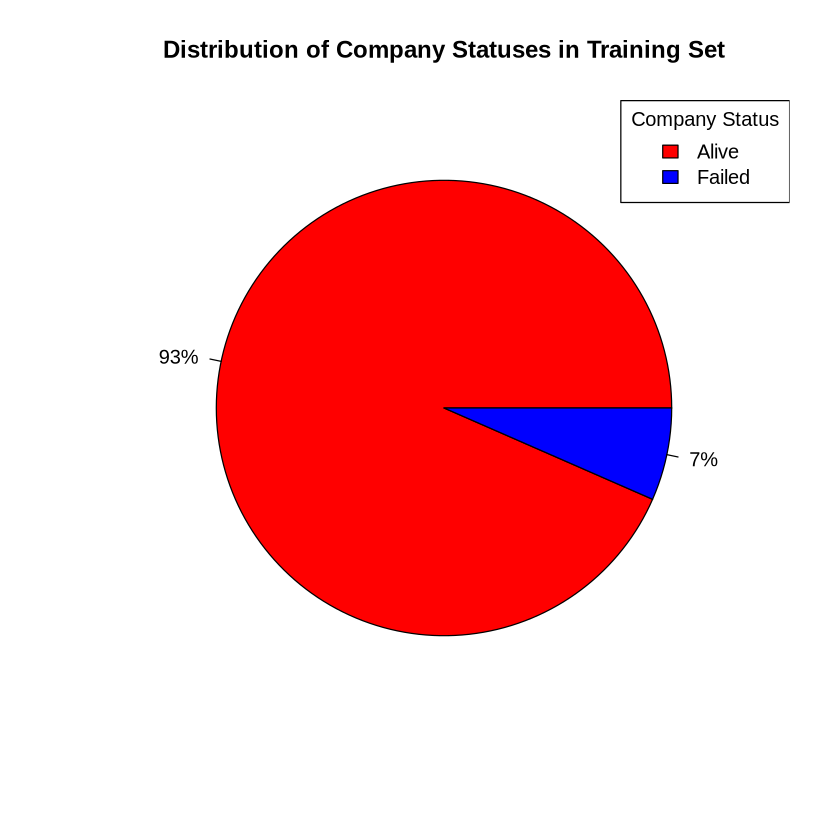

In [3]:
set.seed(1000)

alive <- filter(bank_train, status_label == "alive")
total_number <- nrow(bank_train)
alive_number <- nrow(alive)
failed_number <- total_number - alive_number

pie_data <- c(alive_number, failed_number)
pie_labels <- c("Alive", "Failed")
status_label <- c("Alive", "Failed")
slice_colors <- c("red", "blue")

pie(pie_data, labels = percent(pie_data / sum(pie_data)), col = slice_colors, main = "Distribution of Company Statuses in Training Set")

legend("topright",
    legend = status_label,
    fill = slice_colors,
    title = "Company Status")

The "Alive Ratio" is approximately 93% and the "Failed Ratio" is approximately 7%, which means that 93% of the samples belongs to the "Alive" class (haven't gone bankrupt) and 7% of the samples belongs to the "Failed" class (have gone bankrupt).

We could also claim that this is a highly imbalanced dataset and the model may be biased and cause problems when identifying minority groups. To address the issue, we will use some class balancing techniques like *Synthetic Minority Over-sampling Technique (SMOTE)* to oversample the minority class (Failed).

### Correlation Matrix:

First, we install and load the ***ggplot2*** library to plot the graph:

In [4]:
install.packages("ggplot2")
install.packages("reshape2")
library(ggplot2)
library(reshape2)


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




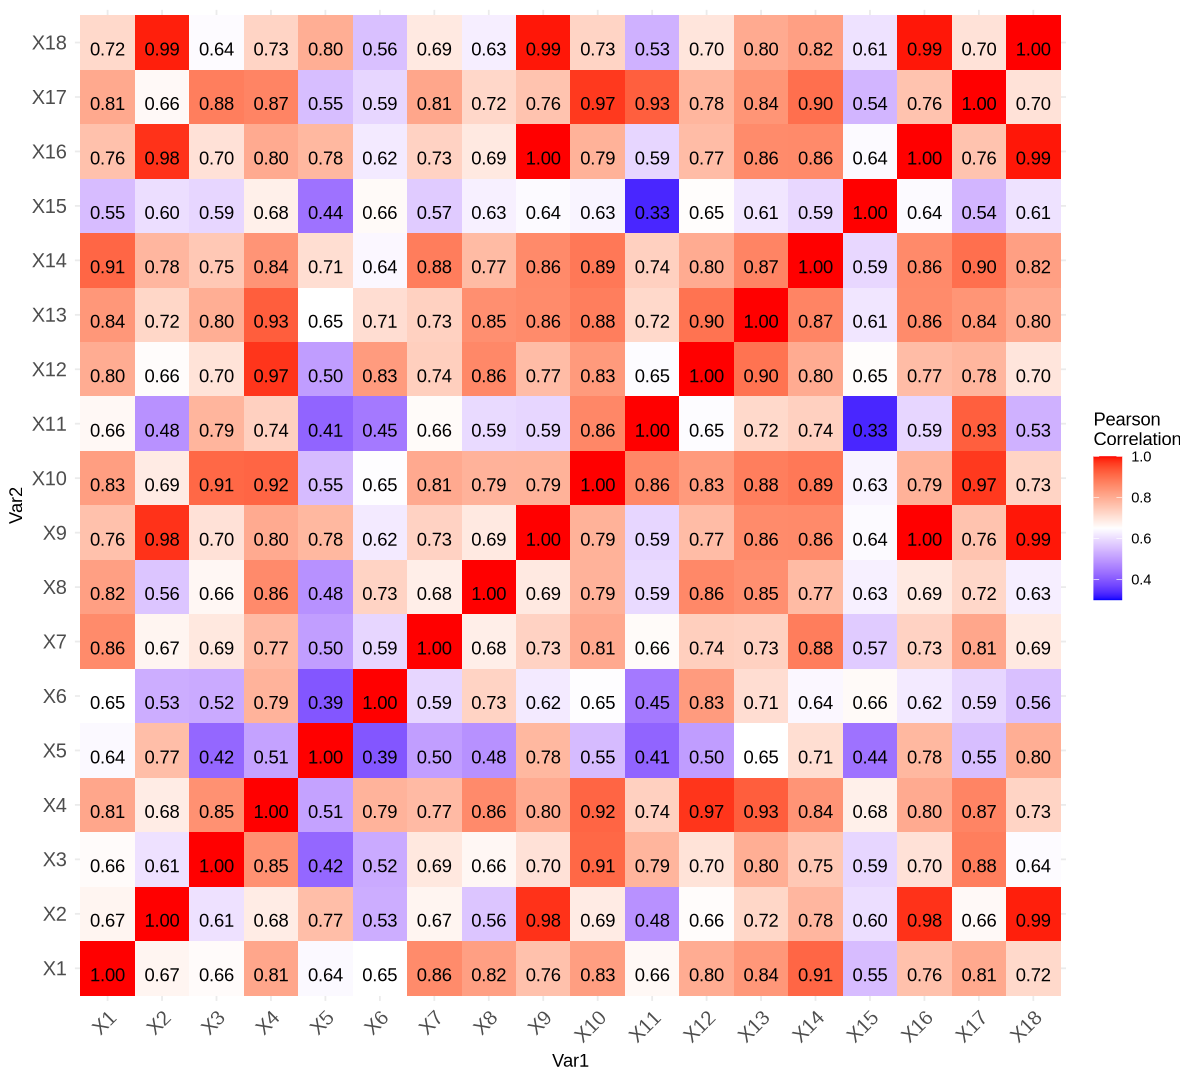

In [9]:
bank_train_select <- select(bank_train, -c(company_name, status_label, year))
cor_bank_train <- cor(bank_train_select)

long_cor <- melt(cor_bank_train)

options(repr.plot.width = 10, repr.plot.height = 9)

ggplot(data = long_cor, aes(x = Var1, y = Var2, fill = value)) +
    geom_tile() +
    geom_text(aes(label = sprintf("%.2f", value)), vjust = 1) +
    scale_fill_gradient2(low = "blue", high = "red", mid = "white",
                         midpoint = 0.65, limit = c(0.3,1), space = "Lab",
                         name="Pearson\nCorrelation") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 12, hjust = 1),
          axis.text.y = element_text(size = 12)) +
    coord_fixed()

As we can see from the Correlation Matrix,  
- *X2 (Cost of Goods Sold)*, *X9 (Net Sales)*, *X16 (Total Revenue)* and *X18 (Total Operating Expenses)* are highly correlated to each other;
- *X4 (EBITDA: Earnings before interest, taxes, depreciation, and amortization)* and *X12 (EBIT: Earnings before interest and taxes)* are highly correlated to each other;
- *X10 (Total Assets)*, *X11 (Total Long-term Debt)* and *X17 (Total Liabilities)* are highly correlated to each other.

## Methods

We will use logistic regression on our training data to determine which variables/columns will be used as predictors in our classifier. We will then use a knn model with our testing data to determine the accuracy of our classifier. Finally, we can use the classifier to classify an observation from our testing data and see if it is accurate.

## Expected Outcomes and Significance 

### What we expect to find:

We expect to find the probability that a certain company goes bankrupt based on definitive factors.

### Impact of the findings: 

These findings can be beneficial to potential business owners who wish to know how successful other businesses in the same fields as them are. They can also be useful to current business owners as this model can help predicting whether their business is headed towards bankruptcy or not.